## Implementation of RNN from scratch for Artificial Intelligence Comp.5430

In [79]:
import matplotlib.pyplot as plt
from Modules.rnn_utils.utilities import *
from Modules.rnnmodel import RNN
import pandas as pd
import pickle

In [80]:
file = '../../archive/A.csv'

df = pd.read_csv(file)

values_df = df['Close'].values

In [81]:
# normalize
scaler = Normalize(values_df, max=True)
normalized = scaler.normalize_data(values_df)

normalized

array([0.15136087, 0.13889081, 0.15136087, ..., 0.68738758, 0.69081022,
       0.66904002])

## Get training and testing inputs and outputs

In [82]:
def train_test_split(df, split=0.75):
    # if split=0.75, splits data into 75% training, 25% test
    # provides targets for training and accuracy measurments
    max_index = round((len(df) - 1) * split)

    # adjusted close price [2 days ago, 1 day ago]
    train_inputs = [[df[i-2], df[i-1]] for i in range(2, max_index)]
    # target is the next day for a given input above
    # e.g inputs = [day1, day2], [day2, day3]
    #     targets = [day3, day4]
    train_targets = [i for i in df[2 : max_index]]

    assert len(train_inputs) == len(train_targets)

    test_inputs = [[df[i-2], df[i-1]] for i in range(max_index + 2, len(df))]
    test_targets = [i for i in df[max_index + 2:]]

    assert len(test_inputs) == len(test_targets)

    return np.array(train_inputs), np.array(train_targets), np.array(test_inputs), np.array(test_targets)

def to_3d(data):
    # reshape data to [inputs, timesteps, features]
    train = data.reshape(data.shape[0], data.shape[1], 1)
    return train

In [83]:
train_inputs, train_targets, test_inputs, test_targets = train_test_split(normalized)

## Train Test Functions

In [84]:
def train(model, input, target):
        epochs = 10
        # For each epoch
        for epoch in range(epochs):
            # list outputs
            if epoch == epochs - 1:
                train_output_list = []
            for i in range(input.shape[0]):
                hidden_states, hidden_output = model.forward(input[i])
                # to measure training accuracy
                if epoch == epochs - 1:
                    # save outputs
                    train_output_list.append(hidden_output.tolist()[0])
                # backprop
                model.backprop(input[i], target[i], hidden_states, hidden_output)
        # Transpose outputs
        train_output_list = np.array(train_output_list).T[0]
        # return trained outputs
        return train_output_list

def test(model, input):
    # list to save output
    test_out_list = []
    # forward step
    for i in range(input.shape[0]):
        hidden_states, hidden_output = model.forward(input[i])
        # save outputs
        test_out_list.append(hidden_output.tolist()[0])
    # conver to array and transpose outputs
    test_out_list = np.array(test_out_list).T[0]
    return test_out_list

In [85]:
# returns 3d array in format [inputs, timesteps, features]
train_inputs = to_3d(train_inputs)
test_inputs = to_3d(test_inputs)

In [86]:
model = RNN(1, 30, 1, 0.0001)
train_outputs = train(model, train_inputs, train_targets)
test_outputs = test(model, test_inputs)

In [94]:
# de-normalize
train_outputs = scaler.denormalize_data(train_outputs)
train_targets = scaler.denormalize_data(train_targets)
test_outputs = scaler.denormalize_data(test_outputs)
test_targets = scaler.denormalize_data(test_targets)

print(type(train_outputs), type(train_targets), type(test_outputs), type(test_targets))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [88]:
# Put RMSE Here
rmse = np.sqrt(np.mean((test_outputs - test_targets) ** 2))
print("RMSE:", rmse)

RMSE: 17.449475205335784


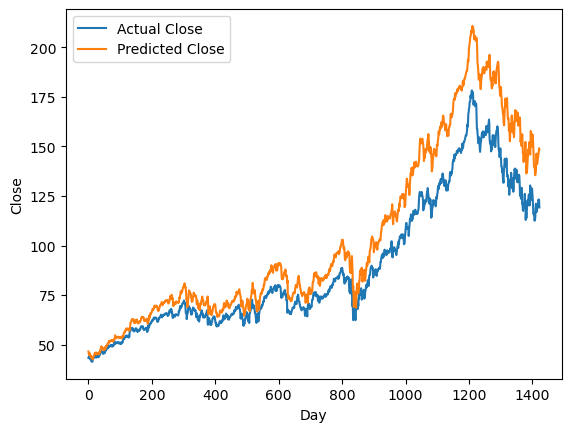

In [89]:
plt.plot(test_targets, label='Actual Close')
plt.plot(test_outputs, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

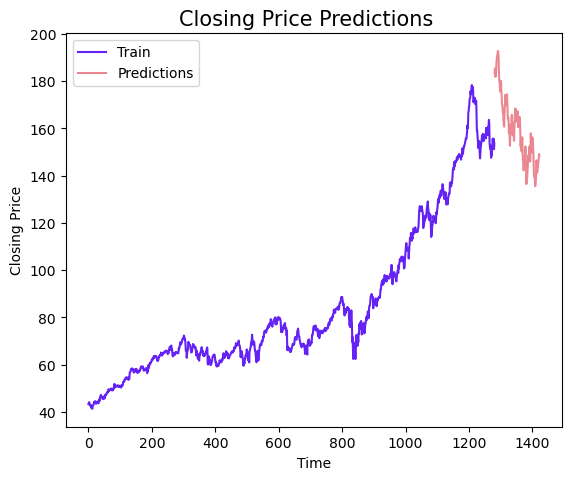

In [90]:
def plot_model_predictions(test, preds):
    plot_test = pd.DataFrame(data=test, index=range(preds.size), columns=['Close'])
    plot_test['Day'] = plot_test.index
    plot_test = plot_test[:int(np.ceil(len(plot_test) * 0.9))]
    plot_pred = pd.DataFrame(data=preds, index=range(test.size), columns=['Predictions'])
    plot_pred['Day'] = plot_pred.index
    plot_pred = plot_pred[int(np.ceil(len(plot_pred) * 0.9)):]

    # fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    # axes[2][1].set_visible(False)
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 15)

    # plt.facecolor('black')
    plt.plot(plot_test['Day'], plot_test['Close'], color = '#6522F5', label = 'Train')
    plt.plot(plot_pred['Day'], plot_pred['Predictions'], color = '#EB8791', label = 'Predictions')
    # plt.set_title('Meta', fontsize = 30)
    plt.xlabel('Time', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    # plt.xaxis.set_tick_params(labelsize = 18)
    # plt.yaxis.set_tick_params(labelsize = 18)
    plt.legend(loc = 'upper left', fontsize = 10)
    
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(test_targets, test_outputs)